In [6]:
import numpy as np
from astropy.coordinates import SkyCoord

a = SkyCoord('19h44m57.7s -14d48m12s')

In [8]:
a.galactic

<SkyCoord (Galactic): (l, b) in deg
    ( 25.3395421, -18.39905205)>

In [1]:
%pylab inline
from astropy.io import fits
import astropy.units as u
# tqdm is just for time keeping -- I suggest you install it, but you can comment it out 
# if you want an take it out of the code
#from tqdm import tqdm
from astroquery import ned
from astropy.wcs import wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord

Populating the interactive namespace from numpy and matplotlib


In [2]:
# This is a cell with all self-defined functions
def coord_NED(dwarfname):
    from astroquery.ned.core import RemoteServiceError
    # get rid of the weird symbos *, (, ), etc, since NED doens't like it
    newname = dwarfname.replace('*','').replace('(','').replace(')', '')

    try:
        target = ned.Ned.query_object(newname)
        ned_exist = True
    except RemoteServiceError: 
        print('NED does not have info, skip: %s/%s\n'%(dwarfname, newname))
        ned_exist= False 
    
    if ned_exist == False:
        tRA, tDEC, tVel, tDist = np.nan, np.nan, np.nan, np.nan
    else: # if NED does have this target, then extract coordinates
        tRA = target["RA(deg)"].data.data[0]
        tDEC = target["DEC(deg)"].data.data[0]
        tVel = target["Velocity"].data.data[0]
        tDist = target["Distance (arcmin)"].data.data[0]
    return tRA, tDEC, tDist, tVel, ned_exist

## transform from vhelio to vlsr 
def vhelio2vlsr_Westmeier(vel_init, ral, decb, reverse=False, doradec=True):
    '''
    - from http://www.atnf.csiro.au/people/Tobias.Westmeier/tools_hihelpers.php
    - obj_ra:  should be in degree
    - obj_dec: should be in degree
    - vel_init: velocity that need to be transformed
    -          vel_init = vhelio if reverse = False
    -          vel_init = vlsr   if reverse = True
    - Favor this one than the other one from Rosolowsky
    '''
    from astropy.coordinates import SkyCoord
    import numpy as np

    if doradec==True:
        c = SkyCoord(ral, decb, unit='deg')
        l = np.radians(c.galactic.l.value)
        b = np.radians(c.galactic.b.value)
    else:
        l = np.radians(ral)
        b = np.radians(decb)
    # vlsr 00> vhelio
    if reverse:
        delv = -(9*np.cos(l)*np.cos(b)+12*np.sin(l)*np.cos(b)+7*np.sin(b))
    else:
        delv = +9*np.cos(l)*np.cos(b)+12*np.sin(l)*np.cos(b)+7*np.sin(b)

    # print 'Velocity correction at this (RA, DEC) is (km/s): ', delv
    return vel_init+delv


def find_the_cube(ra, dec, observation='HI4PI'):
    '''
    Use the input (ra, dec) to decide which cube the data locates.

    observation: most of the time, it is HI4PI or GALFA-HI . 
    
    Note: GALFA-HI table is not available now, will do later 
    '''

    clt = Table.read('tables/%s_RADEC.dat'%(observation), format='ascii')
    cramin, cramax = clt['min_ra'], clt['max_ra']
    cdcmin, cdcmax = clt['min_dec'], clt['max_dec']
    indra = np.all([ra>cramin, ra<cramax], axis=0)
    inddc = np.all([dec>cdcmin, dec<cdcmax], axis=0)
    indall = np.where(np.all([indra, inddc], axis=0) == True)

    cubename = clt['cubename'][indall]
    if len(cubename)==0:
        return ''
    else:
        cubename = cubename[0]

        return cubename

In [3]:
coord_NED('M31')

(10.68479, 41.269060000000003, nan, -300.0, True)

### First double check the dwarf galaxy coordinates with NED 

Step 1: read in target coordinates, and put it in SkyCoord to get the Galactic latitude/longitude (l, b) <br>
Step 2: use (l, b) to convert velocity from heliocentric frame to LSR frame <br>
step 3: check if NED has the target info, if not, skip, if yes, then print out info to compare 

In [12]:
dwtb = Table.read('tables/NearbyGalaxiese_formatted.txt', format='ascii')

for iw, iwtb in enumerate(dwtb):
    
    # S1: get the coordinates from the table directly 
    ra_str = '%dh%dm%ds'%(iwtb['RA_h'], iwtb['RA_m'], iwtb['RA_s'])
    dec_str = '%dd%dm%ds'%(iwtb['Dec_d'], iwtb['Dec_m'], iwtb['Dec_s'])
    icoord = SkyCoord(ra=ra_str, dec=dec_str)
    
    # S2: this function transform vhelio velocity to vlsr velocity 
    vh_2_vlsr = vhelio2vlsr_Westmeier(0, icoord.ra.deg, icoord.dec.deg)
    
    # S3: get coordinates from NED 
    nedinfo = coord_NED(iwtb['GalaxyName'])
    if nedinfo[-1] == True:
        print('%20s / Srs RA     Dec     D     Vel'%('ID'))
        print('%20s / MP  %6.2f %6.2f %6.2f vh%6.2f vlsr%6.2f'%(iwtb['GalaxyName'], icoord.ra.deg, icoord.dec.deg, 
                                                                iwtb['Dist'], 
                                                                iwtb['vh(km/s)'], iwtb['vh(km/s)']+vh_2_vlsr))
                                                         
        print('%20s / NED %6.2f %6.2f %6.2f v?%6.2f\n'%('', nedinfo[0], nedinfo[1], nedinfo[2], nedinfo[3]))

NED does not have info, skip: *CanisMajor/CanisMajor

                  ID / Srs RA     Dec     D     Vel
     SagittariusdSph / MP  283.83 -30.55  17.10 vh140.00 vlsr148.10
                     / NED 283.83 -30.55    nan v?140.00

NED does not have info, skip: *TucanaIII/TucanaIII

NED does not have info, skip: *DracoII/DracoII

                  ID / Srs RA     Dec     D     Vel
            Segue(I) / MP  151.77  16.08  16.80 vh208.50 vlsr204.57
                     / NED 151.77  16.08    nan v?208.00

NED does not have info, skip: *Reticulum2/Reticulum2

NED does not have info, skip: *CetusII/CetusII

NED does not have info, skip: *TriangulumII/TriangulumII

                  ID / Srs RA     Dec     D     Vel
         UrsaMajorII / MP  132.87  63.13  17.50 vh-116.50 vlsr-114.18
                     / NED 132.88  63.13    nan v?-100.00

                  ID / Srs RA     Dec     D     Vel
            BootesII / MP  209.50  12.85  18.10 vh-117.00 vlsr-107.72
                     / NED 

YZ note: After running the cell above, my conclusion is, NED's velocity information is weird ... <br>RA/DEC seem consistent, so let's stay with Mary's table for the rest of this code. 

### Now let's go through each galaxy in the table one by one to see which HI cube you need: <br>
Step 1: read in a galaxy from Mary's table, and use SkyCoord to get RA/DEC <br>
Step 2: find the corresponding GALFA-HI cube and HI4PI cube that contains the data of this galaxy 

In [10]:
dwtb = Table.read('tables/NearbyGalaxiese_formatted.txt', format='ascii')

for iw, iwtb in enumerate(dwtb):
    
    # S1: get the coordinates from the table directly 
    ra_str = '%dh%dm%ds'%(iwtb['RA_h'], iwtb['RA_m'], iwtb['RA_s'])
    dec_str = '%dd%dm%ds'%(iwtb['Dec_d'], iwtb['Dec_m'], iwtb['Dec_s'])
    icoord = SkyCoord(ra=ra_str, dec=dec_str)
    vh_2_vlsr = vhelio2vlsr_Westmeier(0, icoord.ra.deg, icoord.dec.deg)
    
    # find the corresponding GALFA-HI and HI4PI cube names 
    hi4pi_cubename = find_the_cube(icoord.ra.deg, icoord.dec.deg, observation='HI4PI')
    galfa_cubename = find_the_cube(icoord.ra.deg, icoord.dec.deg, observation='GALFA_HI')
    print('%20s is in HI4PI: %7s, and GALFA-HI: %s'%(iwtb['GalaxyName'], hi4pi_cubename, galfa_cubename))

         *CanisMajor is in HI4PI: CAR_D06, and GALFA-HI: 
     SagittariusdSph is in HI4PI: CAR_C15, and GALFA-HI: 
          *TucanaIII is in HI4PI: CAR_B18, and GALFA-HI: 
            *DracoII is in HI4PI: CAR_H12, and GALFA-HI: 
            Segue(I) is in HI4PI: CAR_F08, and GALFA-HI: GALFA_HI_RA+DEC_148.00+18.35_W
         *Reticulum2 is in HI4PI: CAR_B03, and GALFA-HI: 
            *CetusII is in HI4PI: CAR_D01, and GALFA-HI: 
       *TriangulumII is in HI4PI: CAR_G02, and GALFA-HI: GALFA_HI_RA+DEC_036.00+34.35_W
         UrsaMajorII is in HI4PI: CAR_H07, and GALFA-HI: 
            BootesII is in HI4PI: CAR_F11, and GALFA-HI: GALFA_HI_RA+DEC_212.00+10.35_W
             SegueII is in HI4PI: CAR_F02, and GALFA-HI: GALFA_HI_RA+DEC_036.00+18.35_W
            Willman1 is in HI4PI: CAR_G09, and GALFA-HI: 
       ComaBerenices is in HI4PI: CAR_F10, and GALFA-HI: GALFA_HI_RA+DEC_188.00+26.35_W
           *TucanaIV is in HI4PI: CAR_B01, and GALFA-HI: 
          *BootesIII is in HI4PI: CAR_

### Single target study <br>
Now you know which target you want to study, and their RA/DEC/VLSR info, now let's get the HI data <br>
This example is for Leo T

In [22]:
def ellipse_mask_cube(semi_a, semi_b, PA, tar_x, tar_y, cube_header, extend_pix = 0):
    ## make ellipse based on the semi major/minor axies and position angle of the targets 
    
    cube_wh = cube_header['NAXIS1']  # RA
    cube_ht = cube_header['NAXIS2']  # DEC
    x1d = np.arange(cube_wh)
    y1d = np.arange(cube_ht)
    x2d, y2d = np.meshgrid(x1d, y1d)

    # center at the source 
    x2d_nc, y2d_nc = x2d-tar_x, y2d-tar_y

    # this is a rough pixel length for the semimajor and semiminor axis
    semi_a_pix = abs(semi_a / cube_header['CDELT1'])
    semi_b_pix = abs(semi_b / cube_header['CDELT1'])
    
    #### this line #### 
    ## used to be: 
    ### phi = np.radians(90-PA)
    
    phi = np.radians(90+PA)

    # transform to new coordinate system
    xx_prime = x2d_nc*np.cos(phi) + y2d_nc*np.sin(phi)
    yy_prime = -x2d_nc*np.sin(phi) + y2d_nc*np.cos(phi)

    mask_ep = ((xx_prime/(semi_a_pix+extend_pix))**2 + (yy_prime/(semi_b_pix+extend_pix))**2)<=1 
    return mask_ep

In [24]:
coord_NED('M33')

(23.462039999999998, 30.660219999999999, nan, -179.0, True)

In [26]:
# M33 info

objRA, objDEC, objV = 23.46, 30.66, -179
semi_a = 70.8/2/60 # degree, semi major axes
semi_b = 41.7/2/60 # degree, semi minor axes
PA = 23
# degree, I suppose it's angle between semi_a and north, measured toward east? 

In [27]:
vh_2_vlsr = vhelio2vlsr_Westmeier(0, objRA, objDEC)
print(find_the_cube(objRA, objDEC, observation='HI4PI'))
print(vh_2_vlsr)

CAR_F02
-1.52036121458


In [38]:
hdr

SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    3                                                  
NAXIS1  =                  329                                                  
NAXIS2  =                  260                                                  
NAXIS3  =                  680                                                  
CTYPE1  = 'RA      '                                                            
CRVAL1  =  1.8000000000000E+02                                                  
CRPIX1  = -9.2495000000100E+03                                                  
CDELT1  = -1.6666700607100E-02                                                  
CTYPE2  = 'DEC     '                                                            
CRVAL2  =  0.0000000000000E+00                                                  
CRPIX2  = -1.6755000000100E+

In [28]:
#cubename = "data/GALFA_HI_RA+DEC_140.00+18.35_W.fits"
cubename = '/Users/Yong/Dropbox/databucket/M33/GALFA-HI-DR1/M33only.fits'

img1 = fits.getdata(cubename)
hdr = fits.getheader(cubename)

# setting up the WCS
wcsleop =  wcs.WCS(hdr)

# converting to pixel space
tar_x, tar_y, tar_v = wcsleop.all_world2pix(objRA, objDEC, objV*1000, 0)
tar_x = int(tar_x)
tar_y = int(tar_y)
tar_v = int(tar_v)

In [29]:
## figure out how large the area surrounding the source that we want 
ep1 = ellipse_mask_cube(semi_a, semi_b, PA, tar_x, tar_y, hdr, extend_pix=0)
ep2 = ellipse_mask_cube(semi_a, semi_b, PA, tar_x, tar_y, hdr, extend_pix=5)

In [30]:
a = img1[tar_v][ep1]

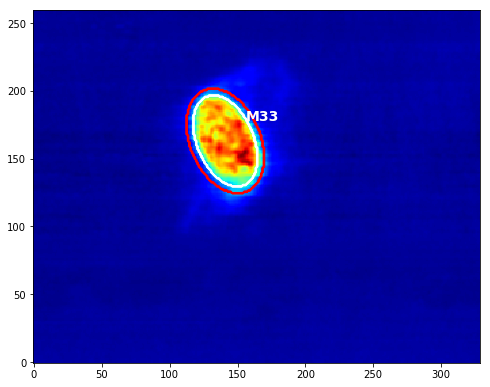

In [31]:
plt.figure(figsize=(8, 8))
plt.imshow(np.sum(img1[tar_v-150:tar_v+150, :, :], axis=0), cmap='jet', origin='lower')
plt.contour(ep1, colors='white')
plt.contour(ep2, colors='r')
plt.text(tar_x+15, tar_y+15, 'M33', color='w', fontsize=14, weight='semibold')

#plt.xlim(0, 50)
#plt.ylim(150, 200)

OK, now let's define a function that measures the total mass at some fiducial distance, here 1 Mpc

In [32]:
    import astropy.units as u
    import astropy.constants as cts
    solM = cts.M_sun.cgs.value  # solar mass in gram
    

In [37]:
mass_cloud(ep1, tar_v, 50, img1, hdr, objDEC, dist=0.84)

<Quantity 107726.61316523638>

In [35]:
def mass_cloud(ep_mask, vpix0, del_pix, data, hdr, objDec, dist=1.0):
    
    tflux = 0 
    for indv in np.arange(vpix0-del_pix, vpix0+del_pix):
        tflux = tflux + np.sum((data[indv, :, :])[ep_mask])
        
    del_cv = hdr['CDELT3']/1e3 # km/s
    kmsK = 1.823e18        # km/s/K  from Tb to cm-2 
    
    import astropy.units as u
    import astropy.constants as cts
    solM = cts.M_sun.cgs  # solar mass in gram
    p_M = cts.m_p.cgs
    
    cdec = np.radians(np.fabs(hdr['CDELT2']*np.pi/180.))
    tmasssolar = (tflux*del_cv*kmsK)*np.cos(np.radians(objDec))*(cdec*dist*u.pc.in_units('cm')*1e6)**2*p_M/solM
    return tmasssolar

In [43]:
def mass_cloud(x0, y0, ch0, r, delch, data, hdr, dec, dist=1.0):
    # first, let's integrate up the cloud
    xx = np.arange(512).reshape([1, 512])*np.ones(512).reshape([512, 1])
    yy = np.arange(512).reshape([512, 1])*np.ones(512).reshape([1, 512])
    wh = ((xx-x0)**2 + (yy-y0)**2) < r**2
    tflux = 0
    for ch in np.arange(ch0-delch, ch0+delch):
        tflux = tflux + np.sum((data[ch, :, :])[wh])
    tmasssolar = tflux*hdr['CDELT3']/1000.*1.8e18*np.cos(dec*np.pi/180.)*(hdr['CDELT2']*np.pi/180.*dist*u.pc.in_units('cm')*1e6)**2*1.6727e-24/1.99e33
    return tmasssolar

In [44]:
leotmass = mass_cloud(int(leotx), int(leoty), int(leotv), radius, halfvelwidth, img1, hdr, leotDEC, dist=0.4)

In [45]:
def err_mass_cloud(ch0, r, delch, data, hdr, dec, dist=1.0):
    offs = []
    for x in tqdm(np.arange(r,512-r, r)):
        for y in np.arange(r, 512-r, r):
            m_off = mass_cloud(x, y, ch0, r, delch, data, hdr, dec, dist=1.0)
            offs.append(m_off)
    return offs

Leo T is not actually a great choice here b/c it's "off" in position space includes the Galaxy, So I chose another velocity off to be farther away.

In [46]:
offs = err_mass_cloud(1024+200, radius, halfvelwidth, img1, hdr, leotDEC, dist=0.4)

100%|██████████| 50/50 [00:14<00:00,  3.71it/s]


In [220]:
print('Leo T has an HI mass of ' + np.str(leotmass/1e6) + 
      ' +/- ' + np.str(np.std(np.asarray(offs)/1e6)) + ' million solar masses')

Leo T has an HI mass of 0.389005426847 +/- 0.119341839403 million solar masses
